In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd().parent.parent.parent.parent/"final_runs/chapter_4/ED/data"
figurepath = Path.cwd()

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [7]:
def model(x,a,b):
    return a*x**b

In [9]:
jobids = []
params = []
data_a3 = []
data_a6 = []
data_nn = []
data = []

folders = [datapath/"N = 15/PBC/xx",datapath/"N = 15/PBC/xx_nn",datapath/"N = 15/OBC/xx",datapath/"N = 15/OBC/xx_nn"]
files = ["combined_file_N15_PBC_xx.jld2","combined_file_N15_PBC_xx_nn.jld2","combined_file_N15_OBC_xx.jld2","combined_file_N15_OBC_xx_nn.jld2"]

for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])


for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])

data_PBC = data[0]
data_PBC_nn = data[1]
data_OBC = data[2]
data_OBC_nn = data[3]

In [10]:
N = 15
hs = [12]
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [11]:
res_PBC = disorder_mean(data_PBC)
res_sem_PBC = disorder_sem(data_PBC)
red_PBC = symmetrize(res_PBC)
red_sem_PBC = symmetrize(res_sem_PBC)

res_PBC_nn = disorder_mean(data_PBC_nn)
res_sem_PBC_nn = disorder_sem(data_PBC_nn)
red_PBC_nn = symmetrize(res_PBC_nn)
red_sem_PBC_nn = symmetrize(res_sem_PBC_nn)

res_OBC = disorder_mean(data_OBC)
res_sem_OBC = disorder_sem(data_OBC)
red_OBC = symmetrize(res_OBC)
red_sem_OBC = symmetrize(res_sem_OBC)

res_OBC_nn = disorder_mean(data_OBC_nn)
res_sem_OBC_nn = disorder_sem(data_OBC_nn)
red_OBC_nn = symmetrize(res_OBC_nn)
red_sem_OBC_nn = symmetrize(res_sem_OBC_nn)

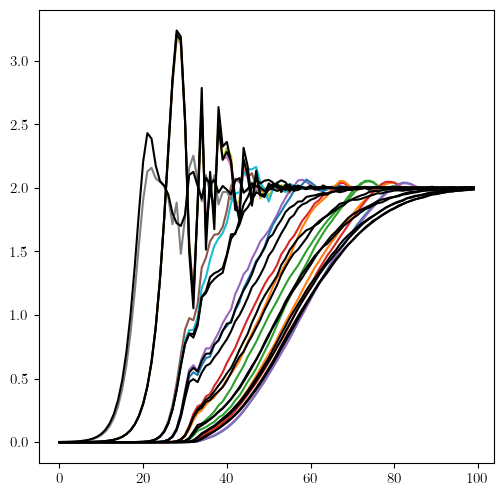

In [17]:
plt.plot(res_PBC)
plt.plot(res_PBC_nn,c="black")

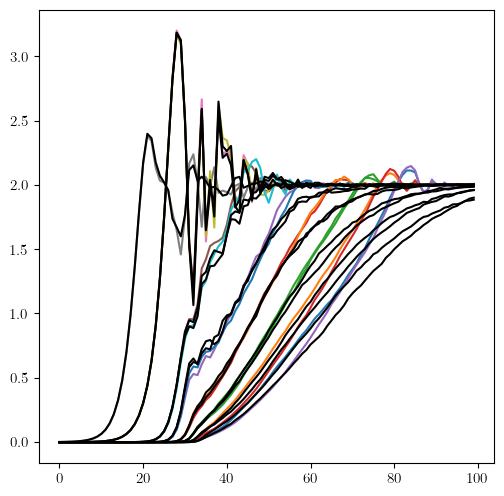

In [18]:
plt.plot(res_OBC)
plt.plot(res_OBC_nn,c="black")

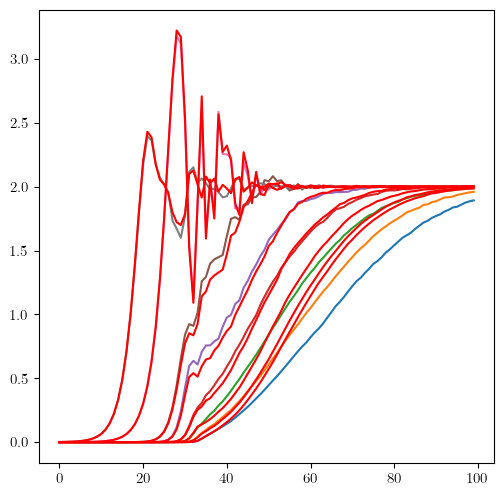

In [34]:
plt.plot(red_OBC_nn)
plt.plot(red_PBC_nn,c="red")

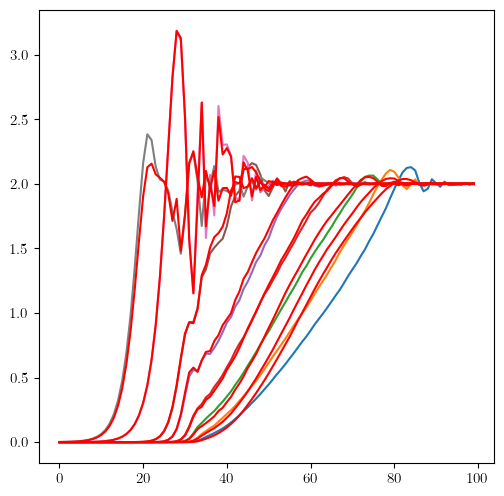

In [35]:
plt.plot(red_OBC)
plt.plot(red_PBC,c="red")

In [12]:
print("h = 12"," PBC: ",data_PBC.shape[2]," PBC_nn: ",data_PBC_nn.shape[2]," OBC: ",data_OBC.shape[2]," OBC_nn: ",data_OBC_nn.shape[2],"\n")

h = 12  PBC:  50  PBC_nn:  50  OBC:  50  OBC_nn:  50 



In [25]:
def model_nn(x,a,b):
    return a*x+b
def model_pl(x,a,b):
    return a*np.log(x)+b

[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[array([ 0.39164684, -1.1178276 ]), array([ 0.42995606, -0.5531773 ]), array([ 0.50103367, -0.0813795 ])] [array([ 1.66530314, -1.75012145]), array([ 1.86095178, -1.31781854]), array([ 2.23656031, -1.19429993])]


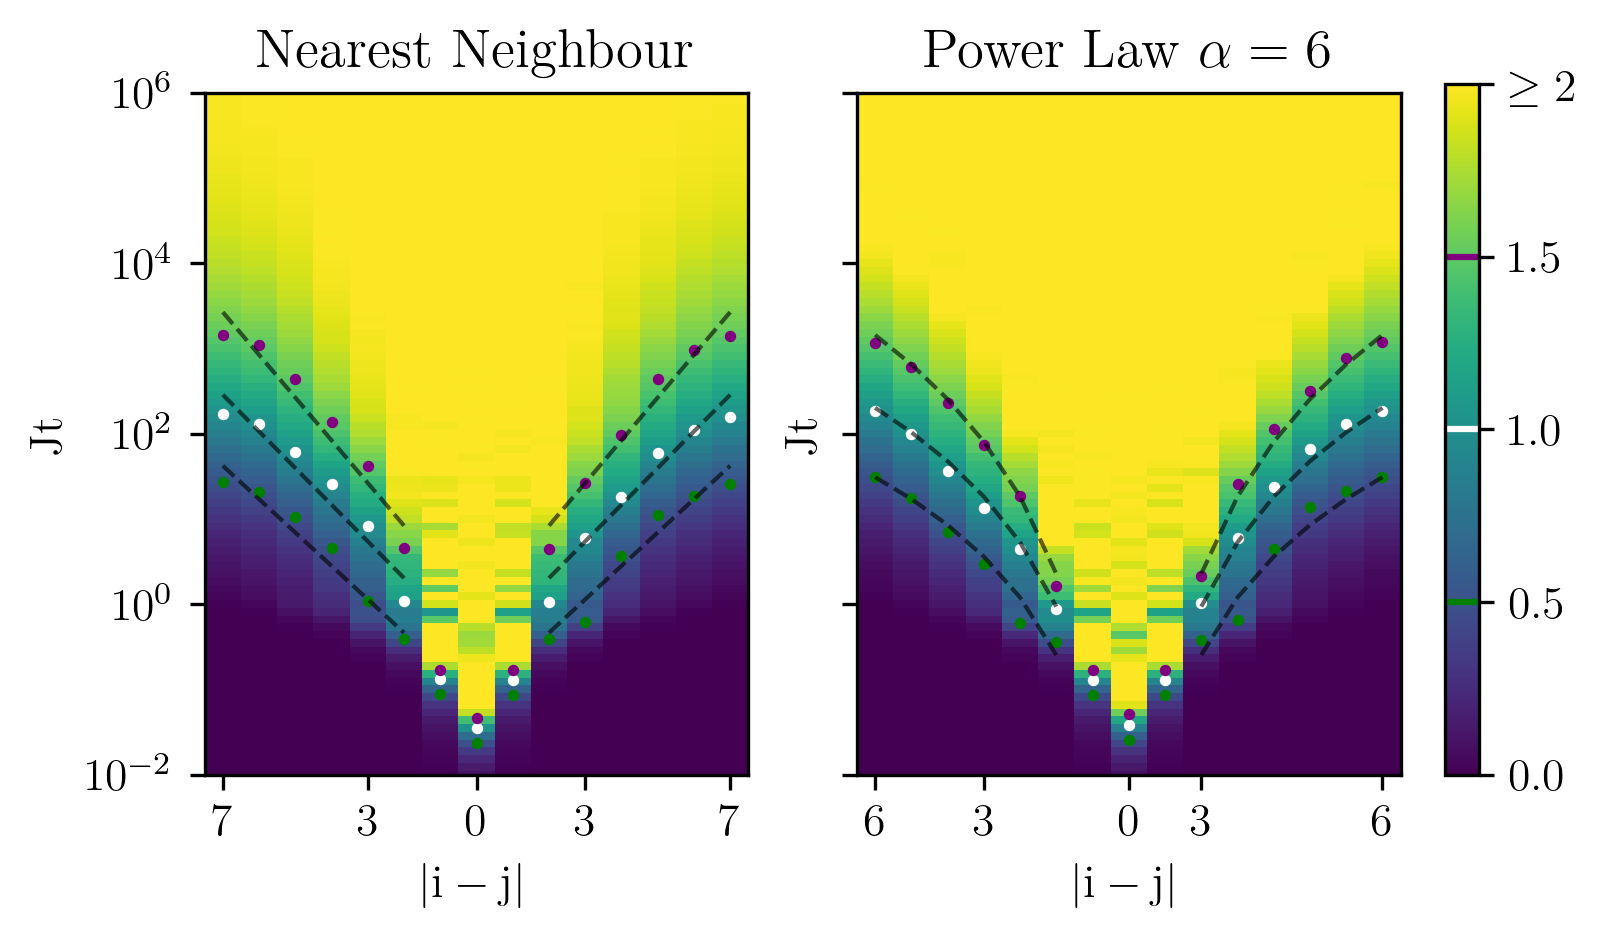

In [28]:
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []

ts = np.zeros((3,6000,13))
ts_pl = np.zeros((3,6000,13))

for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_PBC_nn,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model_nn,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))



    #for s in range(6000):
    #    ts_pl[i,s,:]=T_transgression(T,data[1][:,:,s],th)
    #tvals_pl.append(np.mean(ts_pl,axis=1))
    tvals_pl.append(T_transgression(T,res_PBC,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model_pl,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

print(fit_params,fit_params_pl)

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_PBC_nn,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model_nn(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model_nn(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,4,7,10,N-1])
axs[0].set_xticklabels([7,3,0,3,7])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_PBC,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model_pl(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model_pl(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Result: No real difference visible

[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]


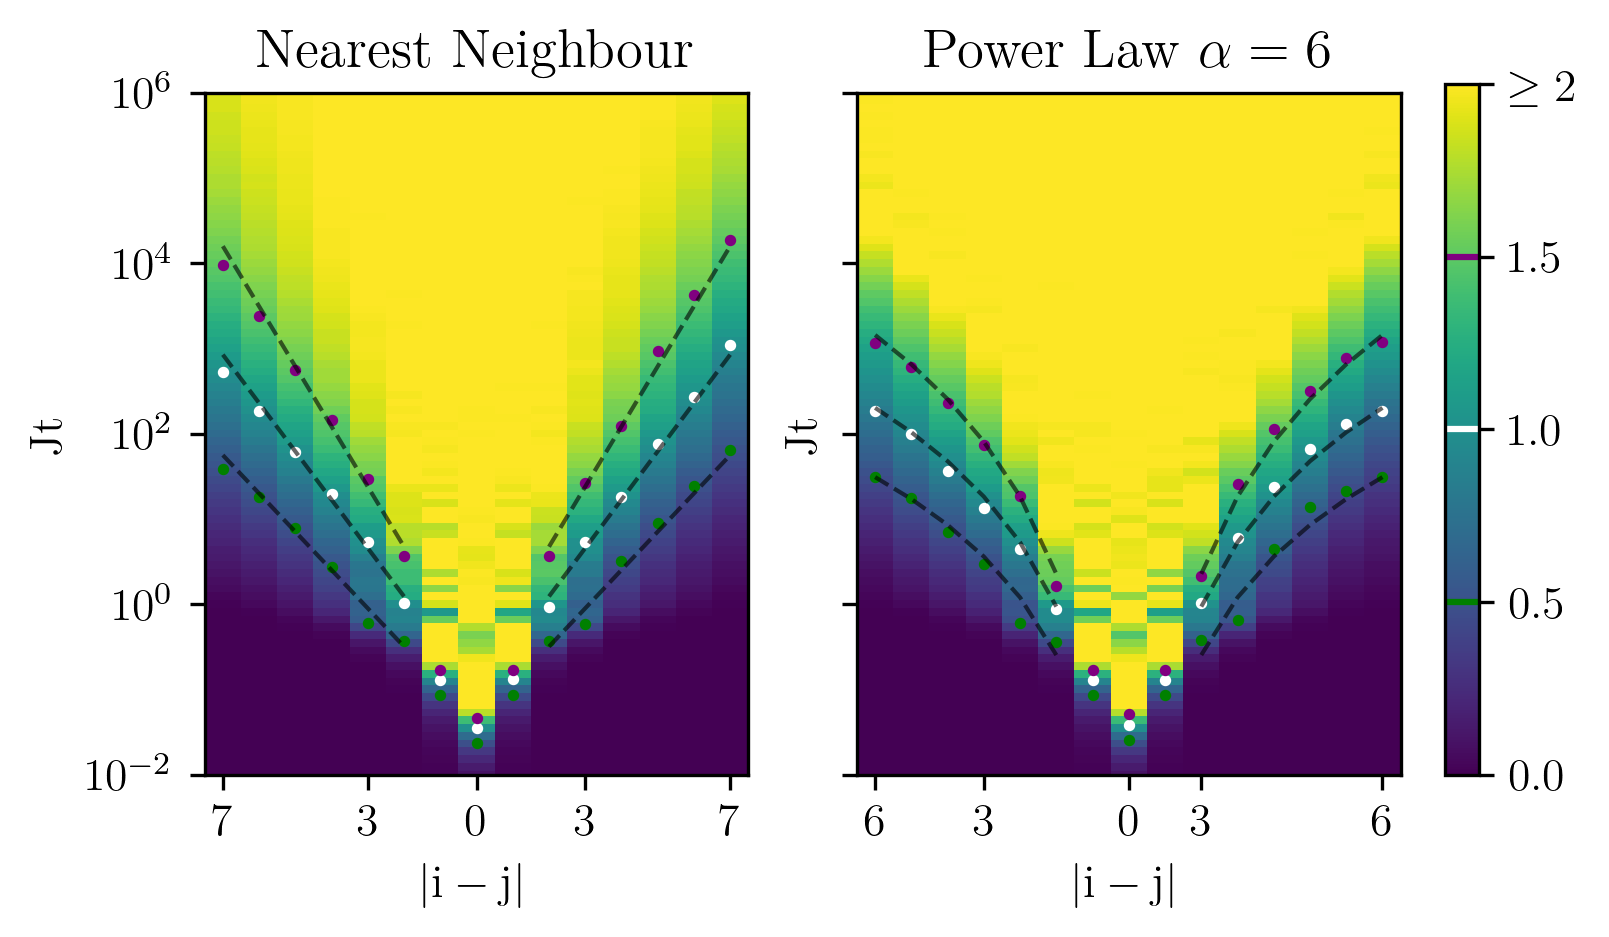

In [27]:
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []

ts = np.zeros((3,6000,13))
ts_pl = np.zeros((3,6000,13))

for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_OBC_nn,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model_nn,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))


    tvals_pl.append(T_transgression(T,res_PBC,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model_pl,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_OBC_nn,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model_nn(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model_nn(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,4,7,10,N-1])
axs[0].set_xticklabels([7,3,0,3,7])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_OBC,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model_pl(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model_pl(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]


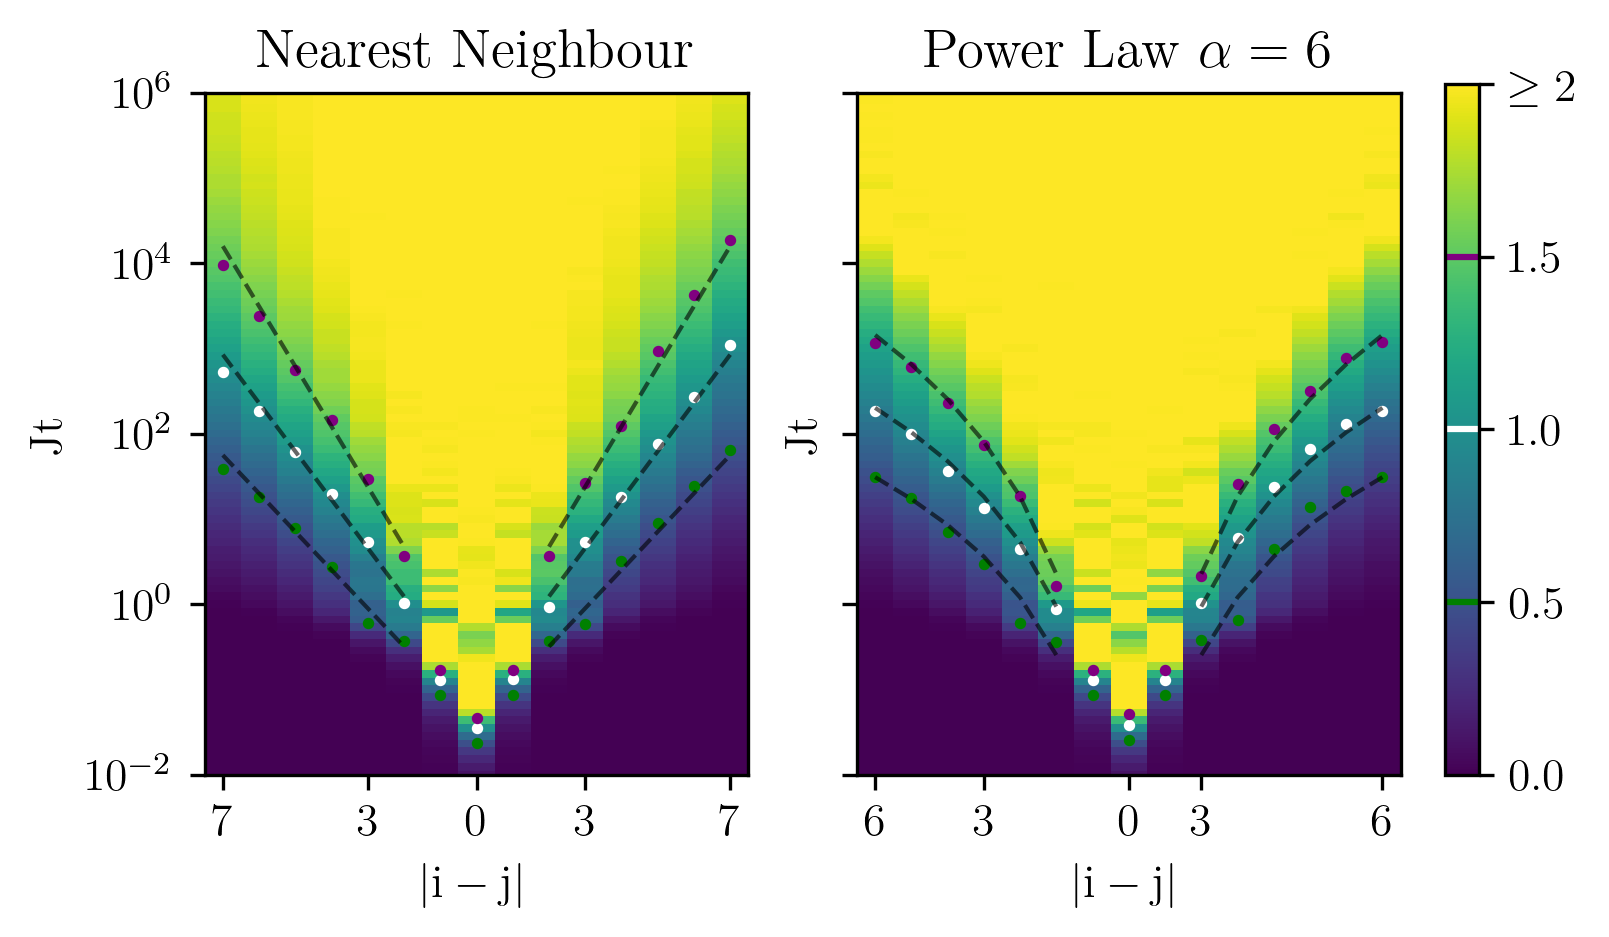

In [33]:
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []

ts = np.zeros((3,6000,13))
ts_pl = np.zeros((3,6000,13))

for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_OBC_nn,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model_nn,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))


    tvals_pl.append(T_transgression(T,res_PBC,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model_pl,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_OBC_nn,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model_nn(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model_nn(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,4,7,10,N-1])
axs[0].set_xticklabels([7,3,0,3,7])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("Nearest Neighbour")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_OBC,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model_pl(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model_pl(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title(r"Power Law $\alpha=6$")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Still shit for comparison. Seems a little bit better but to be brutally honest only 3 points can be used for the fit. The outermost 2 vary too much between PBC and OBC to be credible.

[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]


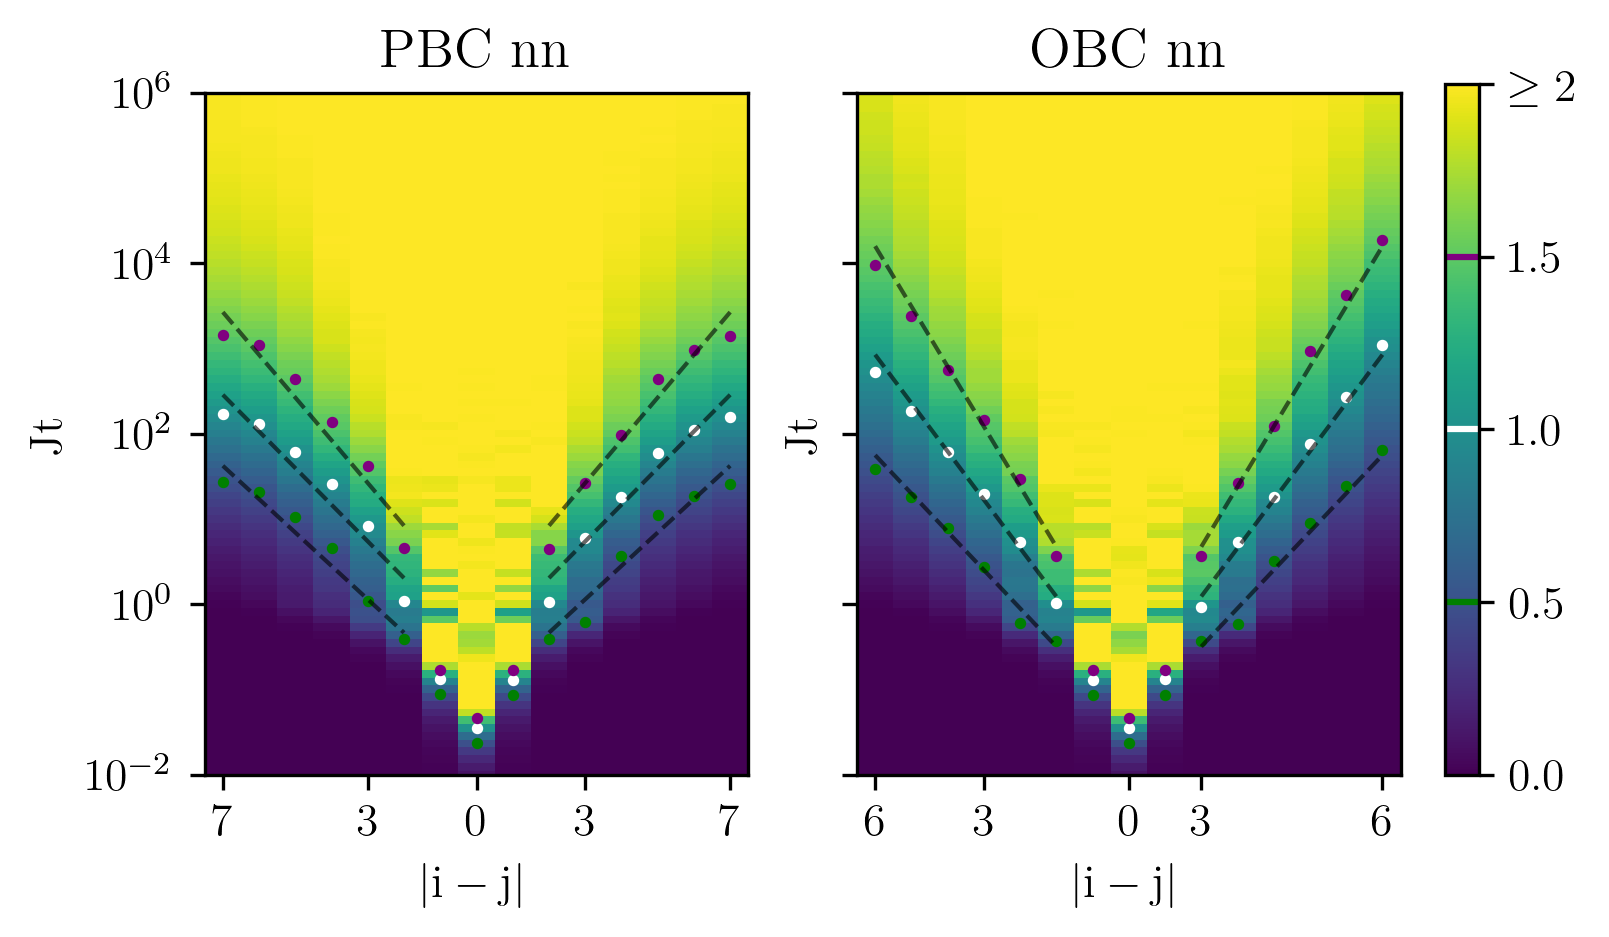

In [38]:
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []


for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_PBC_nn,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model_nn,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))


    tvals_pl.append(T_transgression(T,res_OBC_nn,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model_nn,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_PBC_nn,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model_nn(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model_nn(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,4,7,10,N-1])
axs[0].set_xticklabels([7,3,0,3,7])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("PBC nn")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_OBC_nn,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model_nn(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model_nn(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title("OBC nn")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]
[7 6 5 4 3 2 2 3 4 5 6 7]


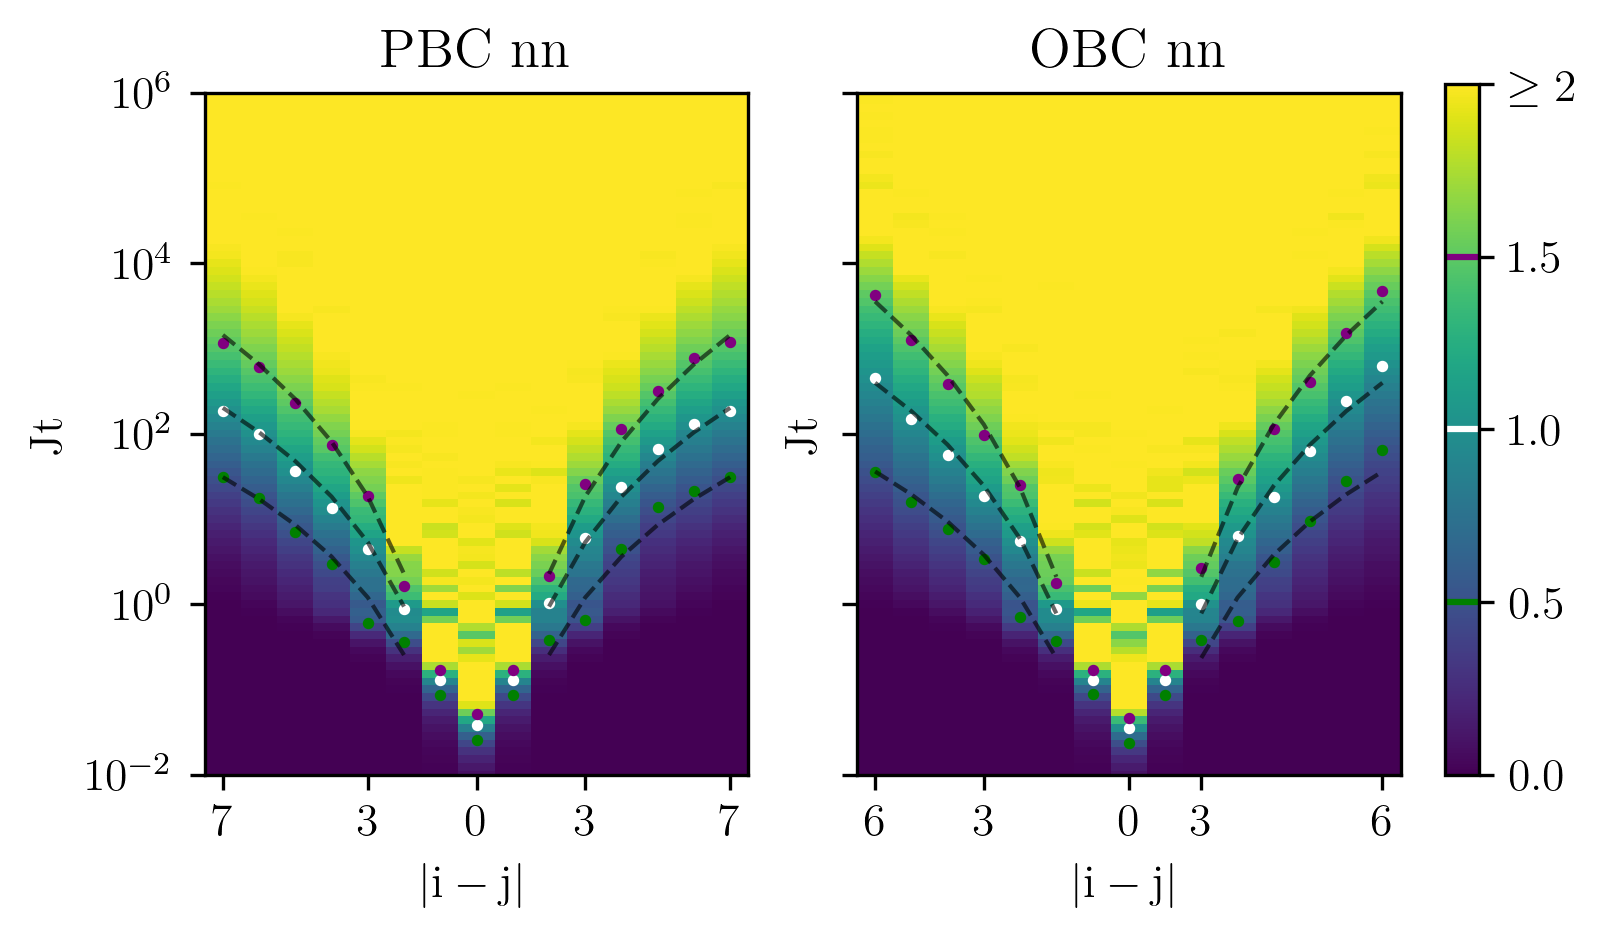

In [39]:
thresholds = [0.5,1.0,1.5]

fit_params = []
fit_errs = []
tvals = []
masks = []
fit_params_pl = []
fit_errs_pl = []
tvals_pl = []
masks_pl = []


for (i,th) in enumerate(thresholds):
    #for s in range(6000):
    #    ts[i,s,:]=T_transgression(T,data_nn[1][:,:,s],th)
    #tvals.append(np.mean(ts,axis=1))
    tvals.append(T_transgression(T,res_PBC,th))
    masks.append(np.isfinite(tvals[i]))
    masks[i][N//2-1:N//2+2] = False
    print(rvals[masks[i]])
    popt, pcov = curve_fit(model_pl,rvals[masks[i]],np.log10(tvals[i][masks[i]]))
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))


    tvals_pl.append(T_transgression(T,res_OBC,th))
    masks_pl.append(np.isfinite(tvals_pl[i]))
    masks_pl[i][N//2-1:N//2+2] = False
    popt, pcov = curve_fit(model_pl,rvals[masks_pl[i]],np.log10(tvals_pl[i][masks_pl[i]]))
    fit_params_pl.append(popt)
    fit_errs_pl.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)


pcm = axs[0].pcolormesh(range(0,N),T,res_PBC,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[0].plot(np.arange(0,N,1)[0:N//2-1],10**model_pl(rvals[0:N//2-1],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[0].plot(np.arange(0,N,1)[N//2+2:],10**model_pl(rvals[N//2+2:],*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[0].plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[0].plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[0].scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 3)

axs[0].set_xlabel(r"$\mathrm{|i-j|}$")
axs[0].set_xticks([0,4,7,10,N-1])
axs[0].set_xticklabels([7,3,0,3,7])
axs[0].set_yscale("log")
axs[0].set_ylabel("Jt")
axs[0].set_ylim(1e-2,1e6)
axs[0].set_title("PBC nn")


pcm2 = axs[1].pcolormesh(range(0,N),T,res_OBC,cmap="viridis",vmin=0,vmax=2)#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    axs[1].plot(np.arange(0,N,1)[:N//2-1],10**model_pl(rvals[0:N//2-1],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    axs[1].plot(np.arange(0,N,1)[N//2+2:],10**model_pl(rvals[N//2+2:],*fit_params_pl[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)

    #axs[1].plot(np.arange(0,N//2,1),tvals_pl[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    #axs[1].plot(np.arange(N//2+1,N,1),tvals_pl[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    axs[1].scatter(np.arange(0,N,1),tvals_pl[i], marker= "o", c = mcolors2[i], s = 3)

axs[1].set_xlabel(r"$\mathrm{|i-j|}$")
axs[1].set_xticks([0,3,N//2,9,N-1])
axs[1].set_xticklabels([6,3,0,3,6])
axs[1].set_yscale("log")
axs[1].set_ylim(1e-2,1e6)
axs[1].set_title("OBC nn")
axs[1].set_ylabel("Jt")


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[0,0.5,1,1.5,2]).ax
cbar_ax.set_visible(False)
cbar.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])

#plt.savefig(figurepath/"MBL_plvsMBL_nn.png",format="png",bbox_inches='tight',dpi=600)
plt.show()